# SETUP

In [ ]:
!nvidia-smi

# IMPORTS

In [ ]:
import random  ,os
import numpy as np 
import pandas as pd
import gc
import time

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import GroupKFold

# torch
import torch
from torch import nn 
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F

import warnings
warnings.simplefilter('ignore')

#Load Data

In [ ]:
train_df = pd.read_csv("https://storage.googleapis.com/umojahack2022/train.csv")
test_df = pd.read_csv("https://storage.googleapis.com/umojahack2022/test.csv")

In [ ]:
print(train_df.shape , test_df.shape)
print('-----------')
print(train_df.Toxin_UniprotID.nunique() , test_df.Toxin_UniprotID.nunique())

# UTILS

In [ ]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def free_memory(sleep_time=0.1):
    """ Black magic function to free torch memory and some jupyter whims """
    gc.collect()
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(sleep_time)

In [ ]:
def get_seq_column_map(train, test, col):
    sequences = []
    for seq in train[col]:
        sequences.extend(list(seq))
    for seq in test[col]:
        sequences.extend(list(seq))
    unique = np.unique(sequences)
    return {k: v for k, v in zip(unique, range(len(unique)))}

def get_column_map(train, test, col):
    sequences = []
    unique_values = pd.concat([train[col], test[col]]).unique().tolist()
    return {k: v for k, v in zip(unique_values, range(len(unique_values)))}

In [ ]:
class AntivenomChallengeDataSet(Dataset):
    def __init__(
        self,
        amino_acid_map,
        antivenom_map,
        data,
        is_train,
        label_name=None,
      ):
        self.amino_acid_map = amino_acid_map
        self.antivenom_map = antivenom_map
        self.data = data
        self.is_train = is_train
        self.label_name = label_name

    def __len__(self):
        return len(self.data) 

    def __getitem__(self,idx):
        row = self.data.iloc[idx]
        kmer_seq = torch.as_tensor([self.amino_acid_map[e] for e in list(row["Toxin_Kmer"])])
        antivenom = torch.as_tensor(self.antivenom_map[row["Antivenom"]])
        position_start = torch.as_tensor(row["Kmer_Position_start"])
        position_end = torch.as_tensor(row["Kmer_Position_end"])
        
        inputs = {
            "K_mer": kmer_seq,
            "antivenom": antivenom,
            "position_start": position_start,
            "position_end": position_end,
        }

        if self.is_train: 
            return inputs, torch.as_tensor([row[self.label_name]])
        return inputs

In [ ]:
class ResidualLSTM(nn.Module):

    def __init__(self, d_model):
        super(ResidualLSTM, self).__init__()
        self.LSTM=nn.LSTM(d_model, d_model, num_layers=1, bidirectional=True,batch_first=True)
        self.linear1=nn.Linear(d_model*2, d_model*4)
        self.linear2=nn.Linear(d_model*4, d_model)

    def forward(self, x):
        res=x
        x, _ = self.LSTM(x)
        x=F.relu(self.linear1(x))
        x=self.linear2(x)
        x=res+x
        return x

class SimpleSeqModel(nn.Module):
    """
    Credits : INstadeepStartNotebook & https://www.kaggle.com/code/shujun717/1-solution-lstm-cnn-transformer-1-fold
    """
    def __init__(
        self,
        K_mer_emb_size,
        K_mer_nunique,
        antivenom_emb_size,
        antivenom_unique,
        max_Position_start,
        Position_start_emb_size,
    ): 
        super().__init__()
        self.K_mer_emb_size = K_mer_emb_size        
        self.K_mer_nunique = K_mer_nunique                
        self.antivenom_emb_size = antivenom_emb_size  
        self.antivenom_unique = antivenom_unique    
        self.rnnlayers = 3
        self.max_seq=None
        self.nlayers=3
        self.dropout=0
        self.nheads=16

        self.Kmer_emb_layer = nn.Embedding( num_embeddings=self.K_mer_nunique,embedding_dim=self.K_mer_emb_size,)
        
        embed_dim =self.K_mer_emb_size
        self.pos_encoder = nn.ModuleList([ResidualLSTM(self.K_mer_emb_size) for i in range(self.rnnlayers)])
        self.pos_encoder_dropout = nn.Dropout(self.dropout)
        self.layer_normal = nn.LayerNorm(embed_dim)
        encoder_layers = [nn.TransformerEncoderLayer(embed_dim, self.nheads, embed_dim*4, self.dropout) for i in range(self.nlayers)]
        conv_layers = [nn.Conv1d(embed_dim,embed_dim,(self.nlayers-i)*2-1,stride=1,padding=0) for i in range(self.nlayers)]
        deconv_layers = [nn.ConvTranspose1d(embed_dim,embed_dim,(self.nlayers-i)*2-1,stride=1,padding=0) for i in range(self.nlayers)]
        layer_norm_layers = [nn.LayerNorm(embed_dim) for i in range(self.nlayers)]
        layer_norm_layers2 = [nn.LayerNorm(embed_dim) for i in range(self.nlayers)]
        self.transformer_encoder = nn.ModuleList(encoder_layers)
        self.conv_layers = nn.ModuleList(conv_layers)
        self.layer_norm_layers = nn.ModuleList(layer_norm_layers)
        self.layer_norm_layers2 = nn.ModuleList(layer_norm_layers2)
        self.deconv_layers = nn.ModuleList(deconv_layers)
        self.pred = nn.Linear(embed_dim, 1)
        self.downsample = nn.Linear(embed_dim*2,embed_dim)

        self.Antivenom_emb = nn.Embedding(num_embeddings=self.antivenom_unique,embedding_dim=self.antivenom_emb_size,)
        self.Position_start_emb = nn.Embedding(num_embeddings=max_Position_start,embedding_dim=Position_start_emb_size,)
        self.Features = nn.Linear(in_features=self.antivenom_emb_size + Position_start_emb_size,out_features=128,)
        self.Linear_1 = nn.Linear(in_features=1152,out_features=512,)
        self.relu_1 = nn.ReLU()
        self.Output = nn.Linear(in_features=self.Linear_1.out_features, out_features=1,)
        
        

    def forward(self, inputs):
        kmer_emb = self.Kmer_emb_layer(inputs["K_mer"])
        for lstm in self.pos_encoder:
            kmer_emb=lstm(kmer_emb)
        kmer_emb = torch.squeeze(kmer_emb)
        kmer_emb = self.pos_encoder_dropout(kmer_emb)
        kmer_emb = self.layer_normal(kmer_emb)

        for conv, transformer_layer, layer_norm1, layer_norm2, deconv in zip(self.conv_layers,self.transformer_encoder,self.layer_norm_layers,
                                                                             self.layer_norm_layers2,self.deconv_layers):
            #LXBXC to BXCXL
            res=kmer_emb
            kmer_emb=F.relu(conv(kmer_emb.permute(1,2,0)).permute(2,0,1))
            kmer_emb=layer_norm1(kmer_emb)
            kmer_emb=transformer_layer(kmer_emb)
            kmer_emb=F.relu(deconv(kmer_emb.permute(1,2,0)).permute(2,0,1))
            kmer_emb=layer_norm2(kmer_emb)
            kmer_emb=res+kmer_emb
        
        antivenom_emb = self.Antivenom_emb(inputs["antivenom"])
        position_start_emb = self.Position_start_emb(inputs["position_start"])
        emb_features = torch.cat((antivenom_emb, position_start_emb), axis=1)
        features = self.Features(emb_features)

        emb = torch.cat((torch.squeeze(kmer_emb[:,1,:], 1), features), axis=1)
        linear_1 = self.relu_1(self.Linear_1(emb))
        output = self.Output(linear_1)

        return output

In [ ]:
def train_func(fold,train_data_loader,val_data_loader,model,loss_fn,optimizer,num_epochs,device,writer,early_stopping=5,):  
    def get_score(y_true, y_pred):
      return mean_squared_error(y_true, y_pred,squared=False)
    
    seed_all()
    total_batches = len(train_data_loader)
    total_batches_val = len(val_data_loader)
    train_loss = []
    
    n_iter = 0
    best_outputs = []
    for epoch in range(num_epochs): 
        tqdm_bar = tqdm(train_data_loader, desc=f"epoch {epoch}", position=0) 
        old_val_loss = np.inf
        wating = 0
        model.train()
        for batch_number, (X, y) in enumerate(tqdm_bar):
            y = y.type(torch.FloatTensor).to(device)
            X = {k: X[k].to(device) for k in X}
            
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            loss = loss.item()
            train_loss.append(loss)

            writer.add_scalar("loss/train", loss, n_iter)
            n_iter += 1

            if batch_number % 25 == 0: 
                tqdm_bar.set_postfix({"train": f"{batch_number}/{total_batches} loss: {loss:.3} epoch loss: {np.mean(train_loss):.3}",},)

        ############## validation  ############## 
        val_tqdm_bar = tqdm(val_data_loader, desc=f"epoch {epoch}", position=0, leave=True,) 
        final_outputs = []
        final_targets = []  
        val_loss = []
        model.eval()
        with torch.no_grad(): 
            for batch_number, (X, y) in enumerate(val_tqdm_bar):
                y = y.type(torch.FloatTensor).to(device)
                X = {k: X[k].to(device) for k in X}
                
                pred = model(X)
                final_outputs.append(pred.cpu().detach().numpy())
                final_targets.append(y.cpu().numpy())
                val_loss.append(loss_fn(pred, y).item())

                writer.add_scalar("loss/validation", np.random.random(), n_iter)
                if batch_number % 25 == 0: 
                    val_tqdm_bar.set_postfix({"valid": f"{batch_number}/{total_batches_val} val loss: {np.mean(val_loss):.3}"},)
        
        new_val_loss = np.mean(val_loss)
        final_targets = np.concatenate(final_targets)
        final_outputs = np.concatenate(final_outputs)
        
        scoree = get_score(final_targets,final_outputs)
        print('Validation RMSE for this epoch',scoree)
        print()
        if new_val_loss > old_val_loss:
            wating += wating
        else:
            old_val_loss = new_val_loss
            best_outputs = final_outputs
            torch.save(model, f"model_fold{fold}.pth")
        if wating > early_stopping:
            break
    return best_outputs

In [ ]:
class Trainer :
  def __init__(self,train_df,test_df) :
    self.train_df = train_df
    self.test_df = test_df
    self.n_splits = 10

    #Data loader params
    self.batch_size = 512
    self.num_workers = 0
    self.shuffle = True
    self.drop_last = False

    # model params
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.num_epochs = 25
    self.early_stopping = 5
    self.lr = 1e-4

  def seed_all(self):
        random.seed(self.SEED_VAL)
        np.random.seed(self.SEED_VAL)
        torch.manual_seed(self.SEED_VAL)
        torch.cuda.manual_seed_all(self.SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(self.SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

  def get_score(self,y_true, y_pred):
    return mean_squared_error(y_true, y_pred,squared=False)

  def Split(self,Train) :
    X      = Train[["Toxin_UniprotID"]]
    y      = Train['Signal']
    groups = Train["Toxin_UniprotID"]
    
    kf = GroupKFold(n_splits=self.n_splits)
    Train["folds"]=-1   
    for fold, (_, val_index) in enumerate(kf.split(X, y,groups=groups)):
          Train.loc[val_index, "folds"] = fold
    return Train

  def TrainKfold(self,) :
    seed_all()
    amino_acid_map = get_seq_column_map(self.train_df, self.test_df, "Toxin_Kmer")
    antivenom_map = get_column_map(self.train_df, self.test_df, "Antivenom")
    max_Position_start = pd.concat([self.train_df[["Kmer_Position_start"]], self.test_df[["Kmer_Position_start"]]]).Kmer_Position_start.max()+1

    self.train_df = self.Split(self.train_df)
    oof = np.zeros((self.train_df.shape[0],1))

    for fold in range(self.n_splits):
      train_split_df = self.train_df[self.train_df.folds != fold]
      val_split_df   = self.train_df[self.train_df.folds == fold]
      val_split_df_index   = self.train_df[self.train_df.folds == fold].index.tolist()

      train_dataset = AntivenomChallengeDataSet(amino_acid_map=amino_acid_map,antivenom_map=antivenom_map,
                                                data=train_split_df,is_train=True,label_name="Signal",)
      val_dataset = AntivenomChallengeDataSet(amino_acid_map=amino_acid_map,antivenom_map=antivenom_map,
                                              data=val_split_df,is_train=True,label_name="Signal",)
      test_dataset = AntivenomChallengeDataSet(amino_acid_map=amino_acid_map,antivenom_map=antivenom_map,data=test_df,is_train=False,)

      train_data_loader = DataLoader(dataset=train_dataset,batch_size=self.batch_size,shuffle=self.shuffle, num_workers=self.num_workers,drop_last=self.drop_last, )
      val_data_loader = DataLoader(dataset=val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,drop_last=False,  )
      test_data_loader= DataLoader(dataset=test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,drop_last=False,)

      

      model = SimpleSeqModel(K_mer_emb_size=1024,K_mer_nunique=len(amino_acid_map),
                            antivenom_emb_size=128,antivenom_unique=len(antivenom_map),
                            max_Position_start=max_Position_start,Position_start_emb_size=64,)

      loss_fn = nn.MSELoss()
      model = model.to(self.device)
      optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
      writer = SummaryWriter()
      writer.add_graph(model, {k: v.to(self.device) for k, v in next(iter(train_data_loader))[0].items()})

      

      oof_fold = train_func(fold,train_data_loader=train_data_loader,val_data_loader=val_data_loader,
                            model=model,loss_fn=loss_fn,optimizer=optimizer,
                            num_epochs=self.num_epochs,device=self.device,writer = writer , early_stopping=self.early_stopping,)

      oof[val_split_df_index] = oof_fold

    return oof

  def INFERENCE(self,) :
    seed_all()
    amino_acid_map = get_seq_column_map(self.train_df, self.test_df, "Toxin_Kmer")
    antivenom_map = get_column_map(self.train_df, self.test_df, "Antivenom")
    max_Position_start = pd.concat([self.train_df[["Kmer_Position_start"]], self.test_df[["Kmer_Position_start"]]]).Kmer_Position_start.max()+1
    test_dataset = AntivenomChallengeDataSet(amino_acid_map=amino_acid_map,antivenom_map=antivenom_map,data=self.test_df,is_train=False,)
    test_data_loader= DataLoader(dataset=test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,drop_last=False,)
    final_preds = []
    for fold in range(self.n_splits):
      path= f"model_fold{fold}.pth"
      model = torch.load(path).to(self.device)
      tqdm_bar = tqdm(test_data_loader, desc=f"Inference-Fold{fold}", position=0, leave=True) 
      total_batches = len(tqdm_bar)

      preds = []
      with torch.no_grad():
          for batch_number, X in enumerate(tqdm_bar):
              X= {k: X[k].to(self.device) for k in X}
              pred = model(X)
              preds.append(pred.cpu().numpy())

          preds = np.concatenate(preds).reshape((-1))
      final_preds.append(preds)
    return np.mean(final_preds,0)

In [ ]:
AssazzinTrainer = Trainer(train_df,test_df)

In [ ]:
free_memory(sleep_time=0.1)
import gc ; gc.collect()

In [ ]:
OOF = AssazzinTrainer.TrainKfold()

In [ ]:
print('OOF RMSE  :',AssazzinTrainer.get_score(train_df['Signal'],OOF))

# INFERENCE & SUBMISSION

In [ ]:
test_pred = AssazzinTrainer.INFERENCE()

In [ ]:
sample_submission=test_df[["ID"]]
sample_submission["Signal"] = np.clip(test_pred,train_df['Signal'].min(),train_df['Signal'].max())
sample_submission.to_csv("AssazzinGoodBaseline_Complex_v3.csv",index=False)

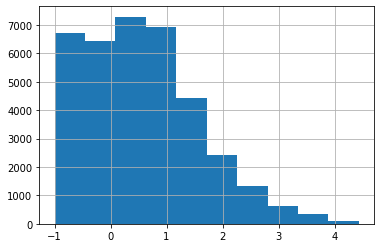

In [ ]:
sample_submission["Signal"].hist()